In [1]:
import os

import pandas as pd
import duckdb
from huggingface_hub import hf_hub_download

from streetscapes import conf
import streetscapes

/home/peter/urban-m4/streetscapes/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploring the Global Streetscapes dataset

Here we familiarize ourselves with the data contained within the Global Streetscapes dataset and introduce some tools and utilities to easily explore it. Most importantly, we will use the huggingface hub package to download the data from huggingface, and we will show how to use duckdb to run powerful queries on the data without memory issues.

### Download using Hugging Face hub

We can use the Hugging Face hub package to download data from the Global Streetscape repo. If the files are already present and up-to-date, they will not be downloaded again. Note that we are passing in the local data directory as specified in the environment/package config. The file `info.csv` contains information about what information is contained in each of the other files.

In [2]:
hf_hub_download(repo_id="NUS-UAL/global-streetscapes", filename="info.csv", repo_type="dataset", local_dir=conf.DATA_DIR)
pd.read_csv(conf.DATA_DIR/"info.csv", index_col=0)

,Filename,Overview,Notes,Field,Format,Explanation
1.0,climate.csv,Contains the Koppen climate zone associated wi...,The calculation is as accurate as the location...,uuid,string,"Universally Unique IDentifier, unique for ever..."
NaN,NaN,NaN,NaN,source,string,"Source of the image, either Mapillary or Karta..."
NaN,NaN,NaN,NaN,orig_id,int,Original ID of the image as specified by Mapil...
NaN,NaN,NaN,NaN,koppen_geiger_zone,string,A zone code to identify the Koppen climate zone
NaN,NaN,NaN,NaN,zone_description,string,Short description of the climate zone
...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,distance_from_prev_m,float,Distance between the image and the previous im...
NaN,NaN,NaN,NaN,distance_from_prev_km,float,Distance between the image and the previous im...
NaN,NaN,NaN,NaN,time_from_prev_s,float,Time duration between the image and the prviou...
NaN,NaN,NaN,NaN,time_from_prev_hr,float,Time duration between the image and the prviou...


This is not quite readable, so we've written a small utility to render this in a nicer way

In [3]:
streetscapes.info.render_info_csv()

- climate.csv - Contains the Koppen climate zone associated with each image's location.
  The calculation is as accurate as the location of the image given by the source, which also relies on the accuracy of the capturing devices. The accuracy could also be affected by the accuracy of the Koppen climate zone classification API from https://github.com/sco-tt/Climate-Zone-API.
    - uuid (string) - Universally Unique IDentifier, unique for every image
    - source (string) - Source of the image, either Mapillary or KartaView
    - orig_id (int) - Original ID of the image as specified by Mapillary or KartaView
    - koppen_geiger_zone (string) - A zone code to identify the Koppen climate zone
    - zone_description (string) - Short description of the climate zone
- contextual.csv - Contains the eight contextual attributes inferred for each image.
  Please refer to Table 3 in the paper for information on accuracy.
    - uuid (string) - Universally Unique IDentifier, unique for every image


There are quite a few files available. We found the following files provide a good starting point.

In [4]:
for filename in [
    "contextual.csv",
    "metadata_common_attributes.csv",
    "segmentation.csv",
    "simplemaps.csv",
    "ghsl.csv",
    "perception.csv",
    "places365.csv",  # note: the interesting column here is called "place", not "Safe" as suggested in info.csv
    "osm.csv",
]:
    print(filename)
    filename = hf_hub_download(
        repo_id="NUS-UAL/global-streetscapes", 
        filename=f"data/{filename}", 
        repo_type="dataset", 
        local_dir=conf.DATA_DIR
    )

contextual.csv
metadata_common_attributes.csv
segmentation.csv
simplemaps.csv
ghsl.csv
perception.csv
places365.csv
osm.csv


### Exploring the data

One option to explore the data is using pandas. However, pandas might not be the most suitable in this case. It has trouble identifying data types and as a result, parses many columns into objects. It also has a tendency to load lots of data into memory. Notice the memory consumption below: the contextual dataset with (only) 10 columns already uses over 800MB. Some of the other datasets are even much bigger. 

In [5]:
df = pd.read_csv(conf.DATA_DIR / "data" / "contextual.csv")
print(df.info())

/tmp/ipykernel_2616/3780738212.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(conf.DATA_DIR / "data" / "contextual.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004551 entries, 0 to 10004550
Data columns (total 11 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   uuid                object
 1   source              object
 2   orig_id             int64 
 3   glare               object
 4   lighting_condition  object
 5   pano_status         object
 6   platform            object
 7   quality             object
 8   reflection          object
 9   view_direction      object
 10  weather             object
dtypes: int64(1), object(10)
memory usage: 839.6+ MB
None


DuckDB might be more suitable to explore this dataset. This package can query the data very efficiently. For example:

In [6]:
duckdb.sql(f"SELECT * FROM '{conf.DATA_DIR / 'data' / 'metadata_common_attributes.csv'}'")

┌──────────────────────────────────────┬───────────┬──────────────────┬────────────────────┬────────────────────┬─────────────────────────┬───────┬───────┬───────┬───────┬────────┬────────┬────────────────────┬─────────────────┬────────────────────┬────────────────────┬────────────────┬────────────────────────┬────────────────────┐
│                 uuid                 │  source   │     orig_id      │        lat         │        lon         │     datetime_local      │ year  │ month │  day  │ hour  │ width  │ height │      heading       │ projection_type │        hFoV        │        vFoV        │ sequence_index │      sequence_id       │ sequence_img_count │
│               varchar                │  varchar  │      int64       │       double       │       double       │        timestamp        │ int64 │ int64 │ int64 │ int64 │ double │ double │       double       │     varchar     │       double       │       double       │     int64      │        varchar         │       int64        

DuckDB can also combine the dataframes very efficiently, so we can easily get a subset of the data using conditions on multiple CSVs:

In [7]:
duckdb.sql(f"""         
            SELECT *
            FROM read_csv('{conf.DATA_DIR}/data/contextual.csv') AS contextual
            JOIN read_csv('{conf.DATA_DIR}/data/simplemaps.csv') AS simplemaps
            USING (UUID, source, orig_id)
            WHERE simplemaps.city = 'Amsterdam' AND contextual.view_direction = 'side'
           """)

┌──────────────────────────────────────┬───────────┬──────────────────┬─────────┬────────────────────┬─────────────┬─────────────────┬───────────────┬────────────┬────────────────┬─────────┬───────────┬────────────┬────────────┬──────────┬──────────┬─────────────┬─────────┬─────────┬───────────────┬─────────┬────────────┬───────────┐
│                 uuid                 │  source   │     orig_id      │  glare  │ lighting_condition │ pano_status │    platform     │    quality    │ reflection │ view_direction │ weather │   city    │ city_ascii │  city_id   │ city_lat │ city_lon │   country   │  iso2   │  iso3   │  admin_name   │ capital │ population │ continent │
│               varchar                │  varchar  │      int64       │ boolean │      varchar       │   boolean   │     varchar     │    varchar    │  boolean   │    varchar     │ varchar │  varchar  │  varchar   │   int64    │  double  │  double  │   varchar   │ varchar │ varchar │    varchar    │ varchar │   double   │  var

We can add the third csv file to get the exact latitude and longitude of each image. 

Now that we have a smaller dataset to work with, we can convert this to a (geo)pandas dataframe so we can easily plot it. The results from a duckdb query can be converted to a pandas dataframe. Subsequently, we will convert that to a geopandas dataframe for plotting.

Let's visualize the perceived beauty of Amsterdam

In [8]:
df = duckdb.sql(f"""         
            SELECT metadata.lat, metadata.lon, perception.Beautiful
            FROM read_csv('{conf.DATA_DIR}/data/perception.csv') AS perception
            JOIN read_csv('{conf.DATA_DIR}/data/simplemaps.csv') AS simplemaps
            USING (UUID, source, orig_id)
            JOIN read_csv('{conf.DATA_DIR}/data/metadata_common_attributes.csv') AS metadata
            USING (UUID, source, orig_id)
            WHERE simplemaps.city = 'Amsterdam'
           """).df()
df.head()

,lat,lon,Beautiful
0,52.372677,4.899867,6.75
1,52.372590,4.899820,2.62
2,52.372433,4.899744,7.71
3,52.372384,4.899714,8.26
4,52.372330,4.899688,7.53


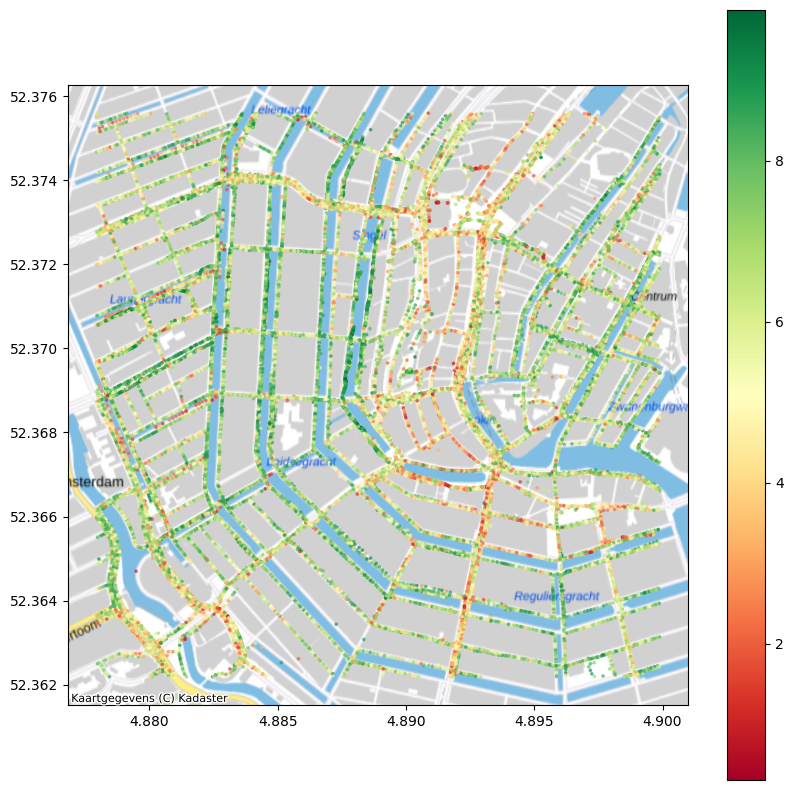

In [9]:
import geopandas as gpd
import contextily

gdf = gpd.GeoDataFrame(df.Beautiful, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
ax = gdf.plot(column='Beautiful', cmap='RdYlGn', legend=True, markersize=3, figsize=(10, 10), alpha=0.5)
contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.standaard)


Interestingly, the wider streets that, from the looks of it are the most busy driveways, are perceived as less beautiful 😲
Let's see if we can confirm this pattern quantitatively:

<Axes: title={'center': 'Beautiful'}, xlabel='type_highway'>

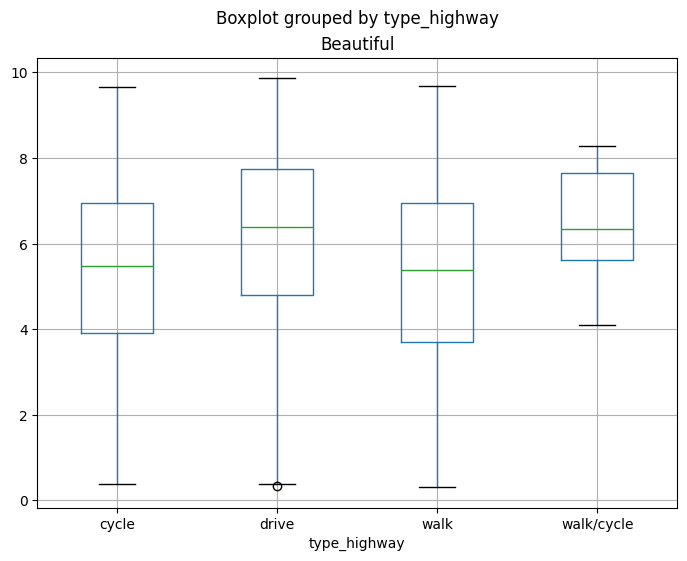

In [63]:
df = duckdb.sql(f"""         
            SELECT perception.Beautiful, osm.type_highway
            FROM read_csv('{conf.DATA_DIR}/data/perception.csv') AS perception
            JOIN read_csv('{conf.DATA_DIR}/data/simplemaps.csv') AS simplemaps
            USING (UUID, source, orig_id)
            JOIN read_csv('{conf.DATA_DIR}/data/osm.csv') AS osm
            USING (UUID, source, orig_id)
            WHERE simplemaps.city = 'Amsterdam'
           """).df().dropna()
df.boxplot(column='Beautiful', by='type_highway', figsize=(8, 6))

This doesn't really line up with what we've seen before, but perhaps we should have a closer look at how each road is classified. OSM also has road_width, but unfortunately, there is much less data available, and the categories are mixed, making it slightly harder to analyse. Since the purpose of this is to familiarize us with the Open Streetscapes dataset and not a full-fledged scientific analysis, we will not dive deeper into it at this point.

## Utility functions

To make it easier to work with the data, we have create a few utility functions that can be imported as part of the streetscapes package.

In [3]:
# Get all columns in a file:
streetscapes.info.get_columns('perception.csv')

['uuid',
 'source',
 'orig_id',
 'Beautiful',
 'Boring',
 'Depressing',
 'Lively',
 'Safe',
 'Wealthy']

In [5]:
# Get unique values in a column in a file
streetscapes.info.get_unique("places365.csv", column="place")

┌────────────────────┐
│       place        │
│      varchar       │
├────────────────────┤
│ downtown           │
│ highway            │
│ alley              │
│ parking_lot        │
│ desert_road        │
│ canal              │
│ bridge             │
│ botanical_garden   │
│ vegetable_garden   │
│ apartment_building │
│     ·              │
│     ·              │
│     ·              │
│ rainforest         │
│ utility_room       │
│ artists_loft       │
│ bow_window         │
│ ice_cream_parlor   │
│ river              │
│ conference_room    │
│ television_room    │
│ pizzeria           │
│ banquet_hall       │
├────────────────────┤
│      345 rows      │
│     (20 shown)     │
└────────────────────┘